In [43]:
from google.cloud import storage
import pandas as pd
import numpy as np
from io import BytesIO
from PIL import Image
import gcsfs
import torch
import torch.optim as optim
import torchvision
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Model import
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet18
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn

In [3]:
USE_COLAB = False
TARGET_SIZE_IM = (256,256)
BATCH_SIZE = 12

In [4]:
# Connect to GCP with columbia authentification google account.
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=S0E0ywlFnE5HW3a5TYnQZMajzq9K0m&prompt=consent&token_usage=remote&access_type=offline&code_challenge=p8OsDANinQqWyPgNO28jAfU8OEGXBjzVCt86pYsLj5E&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AVG7fiTj4n0zLScOqEJ8ZDYFuQHVB7pvkUUaMeMp-P2NnarY1LkJW0KVHSTpV3doMnPFkQ

You are now logged in as [eto2111@columbia.edu].
Your current project i

In [5]:
# Connect to the desired project
!gcloud config set project mypooklacapstone

Updated property [core/project].


## Collect the labels an images from a GCP bucket

In [39]:
client = storage.Client()
# Define your bucket and file path
bucket_name = 'pooklabucket'
bucket = client.get_bucket(bucket_name)

file_path = f"gs://{bucket_name}/food_boxes/Food_boxes_224x224.xlsx"
df_labels = pd.read_excel(file_path, dtype={'filename': str})
print(df_labels.head())

  filename  xmin  ymin  xmax  ymax  label
0   000001    56    32    90    52      1
1   000002   103    56   183   103      1
2   000002    37   110   105   160      1
3   000003    13    53   169   116      1
4   000004   116    46   186    62      1


In [29]:
# Transform the labels as a dict with the boxes and labels to meet the desired input for FastRCNN model
# `targets` will contain one dictionary per unique filename
targets = []

# Group the DataFrame by filename
for filename, group in df_labels.groupby('filename'):
    boxes = []
    labels = []
    for _, row in group.iterrows():
        boxes.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        labels.append(row['label'])

    # Convert lists to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)   # Shape: [num_boxes, 4]
    labels = torch.tensor(labels, dtype=torch.long)     # Shape: [num_boxes]

    # Create the target dictionary for the current filename
    target = {
        'boxes': boxes,
        'labels': labels
    }
    targets.append(target)


print(f'There was {len(df_labels)} rows in df_labels which corresponds to {len(targets)} images')
print(targets[1])
print(targets[2])

There was 137591 rows in df_labels which corresponds to 94088 images
{'filename': '000002', 'boxes': tensor([[103.,  56., 183., 103.],
        [ 37., 110., 105., 160.]]), 'labels': tensor([1, 1])}
{'filename': '000003', 'boxes': tensor([[ 13.,  53., 169., 116.]]), 'labels': tensor([1])}


In [40]:
# Initialize the GCS FileSystem
fs = gcsfs.GCSFileSystem()

# Define your bucket and the folder inside which the images are stored
bucket_name = 'pooklabucket'
folder_path = f"gs://{bucket_name}/food_images/folder_0/"

# List all .jpg images in the folder
file_list = fs.ls(folder_path)

# Load each image and add it along with its file name to the respective list
images = []
images_name = []
for file in tqdm(file_list):
    if file.endswith('.jpg'):
        filename = file.split('/')[-1].split('.')[0]
        images_name.append(filename)

        # Read the image directly from GCS using gcsfs
        with fs.open(file, 'rb') as f:
            img = Image.open(f).convert('RGB')
            images.append(np.array(img))

# Convert list of images to a NumPy array
images_array = np.array(images)
print(f"Loaded {len(images)} images.")
print("Shape of the array:", images_array.shape)

100%|██████████| 10000/10000 [09:43<00:00, 17.14it/s]


Loaded 10000 images.
Shape of the array: (10000, 224, 224, 3)


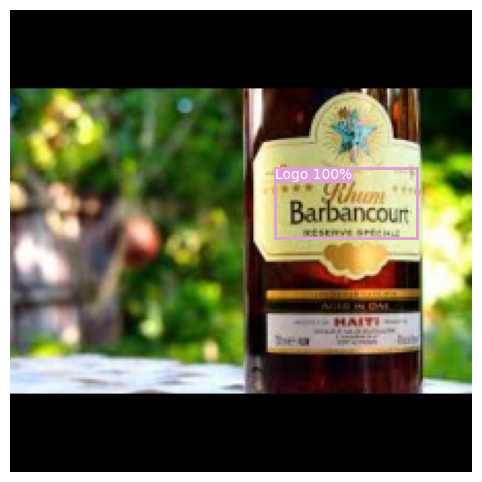

In [42]:
## Quick test to see if the bounding boxes are correct
idx= 7648
classes = ["Background", "Logo"]
filename = images_name[idx]
df_filtered = df_labels[df_labels['filename'] == filename]
boxes = np.array(df_filtered[['xmin', 'ymin', 'xmax', 'ymax']].values)
labels = np.array(df_filtered['label'].values)
nb_boxes = len(boxes)
plot_image(images_array[idx], boxes, np.array([1]*nb_boxes), labels, classes)

In [64]:
## Split the dataset into training and validation
train_images_name, val_images_name = train_test_split(images_name, test_size=0.05, shuffle=True, random_state=5)
train_images, val_images =  train_test_split(images_array, test_size=0.05, shuffle=True, random_state=5)
print(len(train_images))

9500


## Choose a model and train it

The following three models all use the Fast R-CNN architecture, but they differ in the choice of backbone model.

### Model 1: ResNet50

In [47]:
# Backbone model: ResNet50 (nb params= 41,299,161)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device used:', device )
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
num_classes = 2  # Logo + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

device used: cpu
Total number of parameters: 41299161


### Model 2: ResNet18

In [14]:


# Backbone model: ResNet-18 (nb params= 40,325,781)
backbone = resnet18(weights='IMAGENET1K_V1')
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])  # Remove the final layers
backbone.out_channels = 512  # This is the final number of channels in ResNet-18 before the fully connected layers

# Define the anchor generator with sizes suited for Faster R-CNN
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),) * 5)

# Create the model
model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
total_params = sum(p.numel() for p in model.parameters())
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
print(f"Total number of parameters: {total_params}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
 43%|████▎     | 19.1M/44.7M [00:00<00:00, 132MB/s] 


KeyboardInterrupt: 

### Model 3: MobileNetV3

In [60]:
# Backbone model: MobileNetV3 (nb params= 18,930,229)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
model.roi_heads.box_predictor = FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, num_classes=2)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
total_params = sum(p.numel() for p in model.parameters())
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
print(f"Total number of parameters: {total_params}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 163MB/s]


Total number of parameters: 18930229


### The training

In [ ]:
## Training function
BATCH_SIZE = 12
num_epochs = 50

epoch_losses = []
epoch_iou_accuracy = []
for epoch in range(num_epochs):
  model.train()

  # Shuffle the images at each epoch
  shuffled_indices = np.random.permutation(len(images_array))
  img_shuffled = train_images[shuffled_indices]
  imgName_shuffled = train_images_name[shuffled_indices]

  batch_losses = [0]*(len(images_array) // BATCH_SIZE)
  for batch_idx in tqdm(range(len(images_array) // BATCH_SIZE)):
    ### Prepare the training batch #############################################
    # Get the filenames for the current batch
    batch_filenames = imgName_shuffled[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE]

    # Create the batch of training images
    batch_images = img_shuffled[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE]
    batch_images = torch.tensor(np.array(batch_images), dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    batch_images = batch_images.to(device)

    # Filter DataFrame for all filenames in the batch at once
    df_filtered_batch = df_labels[df_labels['filename'].isin(batch_filenames)]
    # Group by filename and create target dictionaries directly on the device
    batch_targets = []
    for _, group in df_filtered_batch.groupby('filename'):
      boxes = torch.tensor(group[['xmin', 'ymin', 'xmax', 'ymax']].values, dtype=torch.float32).to(device)
      labels = torch.tensor(group['label'].values, dtype=torch.int64).to(device)
      batch_targets.append({'boxes': boxes, 'labels': labels})

    ### Compute the loss and update the parameters #############################
    # Compute the loss over the training batch
    loss_dict = model(images, batch_targets) ##### check that I only get the losses and not sth else
    total_loss = sum(loss for loss in loss_dict.values())

    # Make the backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    batch_losses[batch_idx] = total_loss.item()

  # Calculate the average loss for this epoch
  avg_epoch_loss = sum(batch_losses) / len(batch_losses)
  epoch_losses.append(avg_epoch_loss)  # Store the epoch loss

  # Evaluate the model accuracy on the validation set after each epoch
  iou_accuracy = evaluate_iou_val_set(model, val_images, val_images_name, df_labels, BATCH_SIZE, iou_threshold=0.5)
  epoch_iou_accuracy.append(iou_accuracy)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, IoU accuracy on validation: {iou_accuracy:.4f}")

## Temporary save locally the results
epoch_performances_df = pd.DataFrame({
    'Epoch Loss': epoch_losses,
    'Epoch IoU Accuracy': epoch_iou_accuracy
})
epoch_performances_df.to_csv('epoch_performances.csv', index=False)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss.item(),
}, "trained_FastRCNN_model.pth")


Save the model and the evolution of the loss on GCP bucket

In [ ]:
## Reauthenticate to google cloud if needed
# !gcloud auth application-default login


In [ ]:
NUM_TRIAL = 3
# Specify the bucket name and file path in the bucket
bucket_name = "pooklabucket"
output_blob_name = f"model_checkpoints/trained_FastRCNN_model_{NUM_TRIAL}.pth"
output_blob_name_csv = f"model_checkpoints/epoch_performances_{NUM_TRIAL}.csv"

# Initialize the Google Cloud Storage client and specify the bucket
client = storage.Client()
bucket = client.bucket(bucket_name)

# Upload the local file to GCS
blob = bucket.blob(output_blob_name)
blob.upload_from_filename("trained_FastRCNN_model.pth")

# Upload the CSV file
blob2 = bucket.blob(output_blob_name_csv)
blob2.upload_from_filename('epoch_performances.csv')

print(f"Model checkpoint saved to GCS at: gs://{bucket_name}/{output_blob_name}")


### Evaluate the performance of the model

In [ ]:
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
crowdai = ["Background", "Logo"]

# Set model to evaluation mode
model.eval()

# Number of images to visualize
num_batch = 1

# Create your custom data loader (you might already have this part)
BATCH_SIZE = 12
batch_idx = 2

# Disable gradient calculations for evaluation
with torch.no_grad():
    for _ in range(num_batch):  # Loop through the desired number of images
        # Get a batch of images and targets from the data loader
        images = images_array[batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]
        batch_target = targets[batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]
        images = torch.tensor(np.array(images), dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
        # Move images to the correct device
        images = images.to(device)

        # Get model predictions (outputs are lists of dictionaries)
        predictions = model(images)

        # Loop over each image in the batch
        for i in range(len(images)):
            # Move image back to CPU and convert to numpy for plotting
            img = images[i].cpu().permute(1, 2, 0).numpy()

            # Extract predicted boxes, labels, and scores
            pred_boxes = predictions[i]['boxes'].cpu().numpy()  # Predicted bounding boxes
            pred_labels = predictions[i]['labels'].cpu().numpy()  # Predicted labels
            pred_scores = predictions[i]['scores'].cpu().numpy()  # Confidence scores for each box

            max_index = pred_scores.argmax()  # Get the index of the highest score
            best_box = pred_boxes[max_index].reshape(1, -1)  # The best bounding box
            best_label = pred_labels[max_index].reshape(1)  # The best label
            best_score = pred_scores[max_index].reshape(1)  # The highest confidence score


            # Visualize the image with the best predicted box
            plot_image(img, best_box, best_score, best_label, crowdai)


## Function to evaluate the performance of the model

In [61]:
def evaluate_iou_val_set(model, val_images, val_images_name, df_labels, BATCH_SIZE, iou_threshold=0.5):
  '''
  Function that evaluates the performance of the model on the validation set and returns the mean IoU accuracy.

  inputs:
    model: Trained PyTorch model (torch.nn.Module)
    val_images: List of validation images (np.arrays -> [N, H, W, C])
    val_images_name: List of validation image names (np.array[string] -> [N])
    df_labels: DataFrame containing the labels and bounding boxes for the validation images
              (pd.DataFrame -> colname = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'label'])
    BATCH_SIZE: Batch size for evaluation (int)
    iou_threshold: IoU threshold to consider a prediction correct (0 < float <1)

  outputs:
    mean_iou_accuracy: Mean IoU accuracy over all batches of the validation state
  '''
  model.eval()
  with torch.no_grad():
    iou_accuracies = []
    for batch_idx in tqdm(range(len(val_images) // BATCH_SIZE)):
      batch_filenames = val_images_name[batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]

      # Create the batch of training images
      batch_images = val_images[batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]
      batch_images = torch.tensor(np.array(batch_images), dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
      batch_images = batch_images.to(device)

      # Filter DataFrame for all filenames in the batch at once
      df_filtered_batch = df_labels[df_labels['filename'].isin(batch_filenames)]
      # Group by filename and create target dictionaries directly on the device
      batch_targets = []
      for _, group in df_filtered_batch.groupby('filename'):
        boxes = torch.tensor(group[['xmin', 'ymin', 'xmax', 'ymax']].values, dtype=torch.float32).to(device)
        labels = torch.tensor(group['label'].values, dtype=torch.int64).to(device)
        batch_targets.append({'boxes': boxes, 'labels': labels})

      # Forward pass to get predictions
      predictions = model(batch_images)

      # Calculate IoU for this batch
      iou_accuracy = evaluate_iou_for_batch(predictions, batch_targets, iou_threshold)
      iou_accuracies.append(iou_accuracy)

    # Average IoU accuracy over all batches
    mean_iou_accuracy = sum(iou_accuracies) / len(iou_accuracies)
    return mean_iou_accuracy

In [12]:
def plot_image(img, boxes, scores, labels, dataset, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(10, 6))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)
  plt.axis("off")
  plt.show()

In [11]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    box1, box2: [xmin, ymin, xmax, ymax]
    Returns IoU value.
    """
    # Determine the coordinates of the intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute area of intersection
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Compute areas of both the bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union area
    union_area = box1_area + box2_area - inter_area

    # Compute the IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

def evaluate_iou_for_batch(predictions, targets, iou_threshold=0.5):
    """
    Evaluate IoU for a batch of predictions and targets.
    predictions: List of predicted bounding boxes
    targets: List of ground truth boxes
    iou_threshold: IoU threshold to consider a prediction correct
    Returns the IoU accuracy.
    """
    correct_boxes = 0
    total_boxes = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu().numpy()  # Predicted boxes
        true_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes

        for t_box in true_boxes:
            total_boxes += 1
            # Find the predicted box with the highest IoU for this true box
            iou_max = 0
            for p_box in pred_boxes:
                iou = calculate_iou(t_box, p_box)
                if iou > iou_max:
                    iou_max = iou

            # Count as correct if IoU exceeds threshold
            if iou_max >= iou_threshold:
                correct_boxes += 1

    iou_accuracy = correct_boxes / total_boxes if total_boxes > 0 else 0
    return iou_accuracy
